In [1]:
from elk.extraction import extract, Extract, extract_hiddens
from sklearn.linear_model import LogisticRegression
from elk.utils.typing import int16_to_float32, float_to_int16
import torch
import pickle
import torch.nn as nn
from tqdm import tqdm

<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow._fs.FileInfo size changed, may indicate binary incompatibility. Expected 64 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow._fs.FileSelector size changed, may indicate binary incompatibility. Expected 48 from C header, got 72 from PyObject


In [2]:
# read in pickle
with open('activations.pkl', 'rb') as f:
    activations = pickle.load(f)

In [3]:
df = activations

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:

all_xs = []
for i in range(len(df)):
    all_layers = []
    for layer in range(1,13):
        all_layers.append(int16_to_float32(df[i][f'hidden_{layer}'][0, :2]))
    all_layers = torch.stack(all_layers).to(DEVICE).to(torch.float32)
    all_xs.append(all_layers)
all_xs = torch.stack(all_xs).to(DEVICE).to(torch.float32)


x_train = all_xs[:700]
x_test = all_xs[700:]


In [59]:
all_xs.shape

torch.Size([1000, 12, 2, 768])

In [52]:
class Probe(nn.Module):
    def __init__(self):
        super().__init__()
        self.probe = nn.Linear(768,1, bias=True).to(torch.float32)
    def forward(self, x):
        return torch.sigmoid(self.probe(x))
    

def loss(quartet, probe):
    probs = probe(quartet)

def ccs_loss(pair, probe):
    probs = probe(pair)
    l_const = (1 - probs.sum(dim=-2))**2
    # print(l_const.shape)
    l_conf = (probs.min(dim=-2).values)**2
    # print(l_conf.shape)
    # print(l_const.mean(), l_conf.mean())
    return (l_const + l_conf).mean()

def gabe_loss(pair, probe):
    probs = probe(pair)
    l_first = probs.min(dim=-2).values**2
    l_second = (1-probs.max(dim=-2).values)**2
    # l_conf = (probs.max(dim=-2).values)**2
    return (l_first + l_second).mean()


def probe_acc(data, probe):
    with torch.no_grad():
        probs = probe(data)
        correct = (probs.max(dim=-2).indices == 0).sum().item()
    return correct/len(data)

In [61]:
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# do logistic regression with scikit-learn

lr = LogisticRegression(max_iter=1000)
lr_accs = {}
lr_probes = {}


df_train = df[:700]
df_test = df[700:]

for layer in range(1,13):
    xs_lr = []
    for i in range(len(df_train)):
        xs_lr.append(int16_to_float32(df[i][f'hidden_{layer}'][0, 0]))
        xs_lr.append(int16_to_float32(df[i][f'hidden_{layer}'][0, 1]))
        # xs.append(int16_to_float32(df[i][f'hidden_{layer}'][:, 2]))
        # xs.append(int16_to_float32(df[i][f'hidden_{layer}'][:, 3]))
    xs_lr = torch.stack(xs_lr)
    ys_lr = torch.tensor([1, 0] * len(df_train))
    lr.fit(xs_lr, ys_lr)
    lr_outputs = lr.predict_proba(xs_lr)[:, 1]
    p_lr = Probe()
    p_lr.probe.weight = nn.Parameter(torch.tensor(lr.coef_).to(DEVICE).to(torch.float32))
    p_lr.probe.bias = nn.Parameter(torch.tensor(lr.intercept_).to(DEVICE).to(torch.float32))
    
    lr_probes[layer] = p_lr
    lr_accs[layer] = ((lr_outputs[0::2] > lr_outputs[1::2])).mean()
    # accs[layer] = ((lr_outputs[0::4] > lr_outputs[1::4]) & (lr_outputs[0::4] > lr_outputs[2::4]) & (lr_outputs[0::4] > lr_outputs[3::4])).mean()




/home/ubuntu/conda/envs/remix/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/conda/envs/remix/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

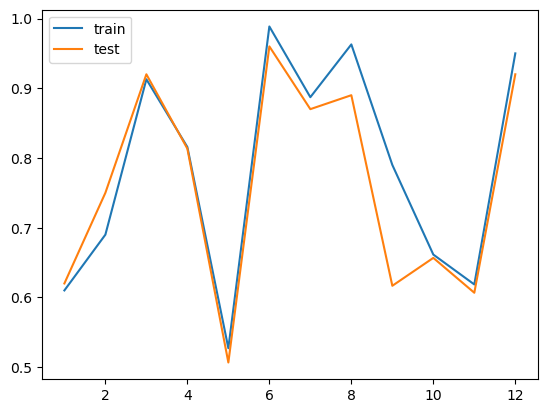

In [56]:

# plot train and test accs using the logistic regression probes and probe_acc

import matplotlib.pyplot as plt
import numpy as np

lr_train_accs = [probe_acc(x_train, lr_probes[i]) for i in range(1,13)]
lr_test_accs = [probe_acc(x_test, lr_probes[i]) for i in range(1,13)]

indices = np.arange(1,13)
plt.plot(indices, lr_train_accs, label='train')
plt.plot(indices, lr_test_accs, label='test')
plt.legend()
plt.show()





In [79]:

epochs = 30000
gabe_probes = {}
gabe_losses = {}

for layer in range(1,13):
    for attempt in range(5):
        p = Probe().to(DEVICE)
        optimizer = torch.optim.Adam(p.parameters(), lr=0.00001)
        for i in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss = gabe_loss(x_train[:, layer-1], p)
            loss.backward()
            optimizer.step()
            # if i % 1000 == 0:
            #     print(loss)
        # save probe if lowest loss so far
        if layer not in gabe_losses or loss < gabe_losses[layer]:
            gabe_losses[layer] = loss
            gabe_probes[layer] = p
            print(f'layer {layer} attempt {attempt} loss {loss}')



100%|██████████| 30000/30000 [00:24<00:00, 1215.67it/s]


layer 1 attempt 0 loss 0.43245962262153625


100%|██████████| 30000/30000 [00:24<00:00, 1224.64it/s]


layer 1 attempt 1 loss 0.4153047502040863


100%|██████████| 30000/30000 [00:24<00:00, 1214.02it/s]


layer 1 attempt 2 loss 0.4000440835952759


100%|██████████| 30000/30000 [00:23<00:00, 1269.70it/s]


layer 2 attempt 0 loss 0.4209226667881012


100%|██████████| 30000/30000 [00:24<00:00, 1231.86it/s]


layer 2 attempt 1 loss 0.2630506753921509


100%|██████████| 30000/30000 [00:24<00:00, 1234.50it/s]


layer 2 attempt 3 loss 0.2573927342891693


100%|██████████| 30000/30000 [00:23<00:00, 1252.32it/s]


layer 3 attempt 0 loss 0.23337532579898834


100%|██████████| 30000/30000 [00:24<00:00, 1237.23it/s]


layer 3 attempt 1 loss 0.18847613036632538


100%|██████████| 30000/30000 [00:23<00:00, 1254.30it/s]


layer 4 attempt 0 loss 0.32965219020843506


100%|██████████| 30000/30000 [00:23<00:00, 1261.96it/s]


layer 4 attempt 1 loss 0.25954481959342957


100%|██████████| 30000/30000 [00:24<00:00, 1243.04it/s]


layer 4 attempt 3 loss 0.1724415421485901


  6%|▌         | 1728/30000 [00:01<00:23, 1223.54it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_1925896/2705400783.py:11 in <module>                                              │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_1925896/2705400783.py'                      │
│                                                                                                  │
│ /tmp/ipykernel_1925896/3560386547.py:22 in gabe_loss                                             │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_1925896/3560386547.py'                      │
│                                                                                                  │
│ /home/ubuntu/conda/envs/remix/lib/python3.10/site-packages/torch/nn/modules/module.py:1194 in    │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1191 │   │   # this function, and just call forward.                                           │
│   1192 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1193 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1194 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1195 │   │   # Do not call functions when jit is used                                          │
│   1196 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1197 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /tmp/ipykernel_1925896/3560386547.py:6 in forward                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_1925896/3560386547.py'                      │
│                                                                                                  │
│ /home/ubuntu/conda/envs/remix/lib/python3.10/site-packages/torch/nn/modules/module.py:1194 in    │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1191 │   │   # this function, and just call forward.                                           │
│   1192 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1193 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1194 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1195 │   │   # Do not call functions when jit is used                                          │
│   1196 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1197 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /home/ubuntu/conda/envs/remix/lib/python3.10/site-packages/torch/nn/modules/linear.py:114 in     │
│ forward                                                                                          │
│                                                                                                  │
│   111 │   │   │   init.uniform_(self.bias, -bound, bound)                                        │
│   112 │                                                    

In [71]:
epochs = 30000
ccs_probes = {}
ccs_losses = {}

for layer in range(1,13):
    for attempt in range(5):
        p = Probe().to(DEVICE)
        optimizer = torch.optim.Adam(p.parameters(), lr=0.00001)
        for i in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss = ccs_loss(x_train[:, layer-1], p)
            loss.backward()
            optimizer.step()
            # if i % 1000 == 0:
            #     print(loss)
        if layer not in ccs_losses or loss < ccs_losses[layer]:
            ccs_losses[layer] = loss
            ccs_probes[layer] = p
            print(f'layer {layer} attempt {attempt} loss {loss}')



100%|██████████| 30000/30000 [00:24<00:00, 1248.14it/s]


In [76]:
import matplotlib.pyplot as plt
import numpy as np

lr_train_accs = [probe_acc(x_train[:, i-1], lr_probes[i]) for i in range(1,13)]
gabe_train_accs = [probe_acc(x_train[:, i-1], gabe_probes[i]) for i in range(1,13)]
gabe_train_accs = [acc if acc > 0.5 else 1-acc for acc in gabe_train_accs]
ccs_train_accs = [probe_acc(x_train[:, i-1], ccs_probes[i]) for i in range(1,13)]
ccs_train_accs = [acc if acc > 0.5 else 1-acc for acc in ccs_train_accs]

lr_test_accs = [probe_acc(x_test[:, i-1], lr_probes[i]) for i in range(1,13)]
gabe_test_accs = [probe_acc(x_test[:, i-1], gabe_probes[i]) for i in range(1,13)]
gabe_test_accs = [acc if acc > 0.5 else 1-acc for acc in gabe_test_accs]
ccs_test_accs = [probe_acc(x_test[:, i-1], ccs_probes[i]) for i in range(1,13)]
ccs_test_accs = [acc if acc > 0.5 else 1-acc for acc in ccs_test_accs]



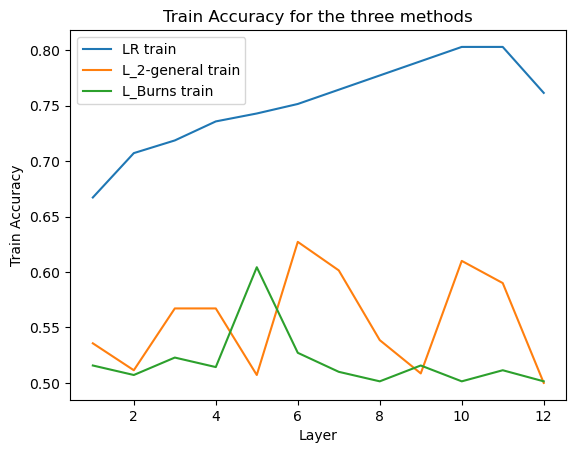

In [80]:
indices = np.arange(1,13)
plt.plot(indices, lr_train_accs, label='LR train')
plt.plot(indices, gabe_train_accs, label='L_2-general train')
plt.plot(indices, ccs_train_accs, label='L_Burns train')
plt.xlabel('Layer')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy for the three methods')

plt.legend()
plt.show()


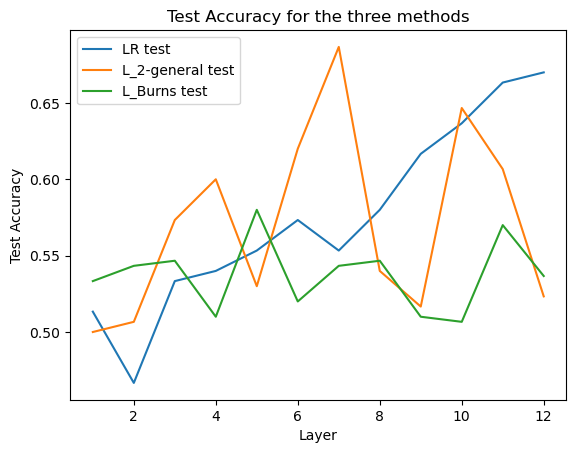

In [82]:
indices = np.arange(1,13)
plt.plot(indices, lr_test_accs, label='LR test')
plt.plot(indices, gabe_test_accs, label='L_2-general test')
plt.plot(indices, ccs_test_accs, label='L_Burns test')

plt.xlabel('Layer')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy for the three methods')

plt.legend()
plt.show()
